In [3]:
import torch
import clip
from PIL import Image

In [4]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

dataset = datasets.ImageFolder(
    root="data",
    transform=preprocess
)

# DataLoader for batching
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [7]:
import matplotlib.pyplot as plt


all_embeddings = []
with torch.no_grad():
    for images, _ in dataloader:  # we ignore class labels
        images = images.to(device)
        features = model.encode_image(images)
        features /= features.norm(dim=-1, keepdim=True)
        all_embeddings.append(features)

embeddings = torch.cat(all_embeddings, dim=0)

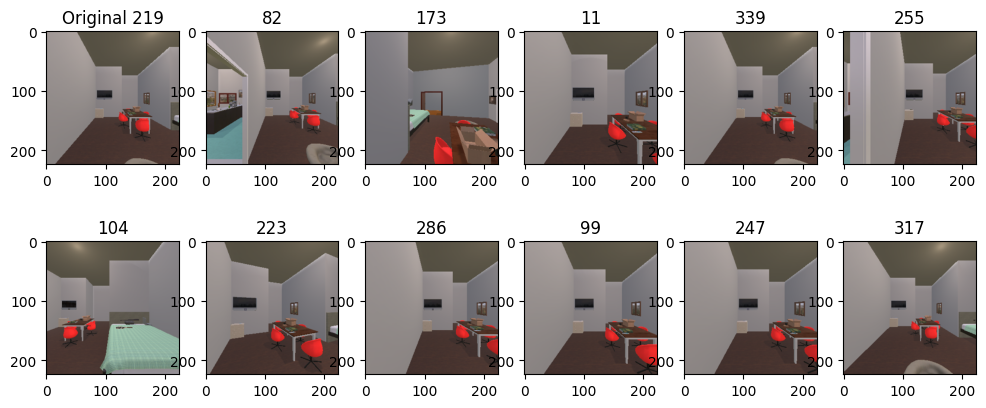

In [9]:
embeddings_norm = embeddings / torch.norm(embeddings, dim=1, keepdim=True)

query_idx = torch.randint(0, len(dataset), (1,))[0]
query = embeddings_norm[query_idx]
similarities = embeddings_norm @ query  # shape (N,)

k = 11
topk_idx = similarities.argsort()[-k-1:-1]

CLIP_MEAN = torch.tensor([0.48145466, 0.4578275, 0.40821073])
CLIP_STD  = torch.tensor([0.26862954, 0.26130258, 0.27577711])

def denormalize(tensor):
    """
    Undo CLIP preprocessing normalization.
    Input: torch tensor of shape (3, H, W)
    Output: numpy array in [0,1] range
    """
    img = tensor * CLIP_STD[:, None, None] + CLIP_MEAN[:, None, None]
    img = torch.clamp(img, 0, 1)
    return img.permute(1, 2, 0).cpu().numpy()

image, _ = dataset[query_idx]
i = 1
plt.figure(figsize=(k + 1,5))
plt.subplot(2, int((k + 1) / 2), i)
plt.imshow(denormalize(image))
plt.title(f"Original {query_idx}")
i += 1
for idx in topk_idx:
    plt.subplot(2, int((k + 1) / 2), i)
    image, _ = dataset[idx]
    plt.imshow(denormalize(image))
    plt.title(str(idx.item()))
    i += 1
plt.show()

In [ ]:
from ram.models import ram, tag2text
from ram import inference_ram, get_transform
from torchvision.transforms.functional import to_pil_image

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ram(pretrained=None, image_size=384, vit='swin_l')

#replace with your local path (wget did not work for me)
#https://huggingface.co/spaces/xinyu1205/recognize-anything/blob/main/ram_swin_large_14m.pth
checkpoint = torch.load(
    "ram_swin_large_14m.pth",
    map_location=device,
)
model.load_state_dict(checkpoint['model'], strict=False)
model.eval().to(device)

/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is tied
/encoder/layer/0/crossattention/self/value is tied
/encoder/layer/0/crossattention/output/dense is tied
/encoder/layer/0/crossattention/output/LayerNorm is tied
/encoder/layer/0/intermediate/dense is tied
/encoder/layer/0/output/dense is tied
/encoder/layer/0/output/LayerNorm is tied
/encoder/layer/1/crossattention/self/query is tied
/encoder/layer/1/crossattention/self/key is tied
/encoder/layer/1/crossattention/self/value is tied
/encoder/layer/1/crossattention/output/dense is tied
/encoder/layer/1/crossattention/output/LayerNorm is tied
/encoder/layer/1/intermediate/dense is tied
/encoder/layer/1/output/dense is tied
/encoder/layer/1/output/LayerNorm is tied


RAM(
  (visual_encoder): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        dim=192, input_resolution=(96, 96), depth=2
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=192, input_resolution=(96, 96), num_heads=6, window_size=12, shift_size=0, mlp_ratio=4.0
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=192, window_size=(12, 12), num_heads=6
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-

In [97]:
dataset_tags = []
tag_ids= []
transform_ram = get_transform(image_size=384)

dataset_tags = []
for img_tensor, _ in dataloader:
    for img in img_tensor:
        pil_img = to_pil_image((img * 0.5 + 0.5).clamp(0,1))
        ram_input = transform_ram(pil_img).unsqueeze(0).to(device)
        #print(transform_ram(pil_img).unsqueeze(0).shape)
        tags, _ = inference_ram(ram_input, model)
        dataset_tags.append(tags)


all_tags = sorted({tag for tags in dataset_tags for tag in tags})

for i in range (len(all_tags)):
    tag_ids.append((all_tags[i],i)) 

print(f"unique tags: {len(tag_ids)}")

unique tags: 28


In [ ]:
def tags_to_onehot(tags):
    onehot = torch.zeros(len(tag_ids), device=device)
    for tag in tags:
        onehot[tag_ids[tag]] = 1
    return onehot

image_vectors = torch.stack([tags_to_onehot(x) for x in dataset_tags])
image_vectors_norm = image_vectors / image_vectors.norm(dim=1, keepdim=True)


In [101]:
CLIP_MEAN = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=device)
CLIP_STD  = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=device)

def denormalize(tensor):
    img = tensor * CLIP_STD[:, None, None] + CLIP_MEAN[:, None, None]
    img = torch.clamp(img, 0, 1)
    return img.permute(1, 2, 0).cpu().numpy()

torch.Size([257, 28])
Query image index: 95
Query tags: bottle | carpet | floor | room | stool

Top-k most similar frames:
 1. Image index: 199
   Tags: armchair | blue | carpet | chair | couch | table | dinning table | floor | furniture | hassock | living room | room | stool
 2. Image index: 82
   Tags: carpet | ceiling | chair | table | floor | furniture | hassock | image | living room | modern | photo | room | stool
 3. Image index: 396
   Tags: armchair | bedroom | carpet | chair | computer | computer desk | floor | furniture | hassock | living room | room | stool
 4. Image index: 51
   Tags: armchair | blue | carpet | ceiling | couch | fill | floor | furniture | hassock | living room | modern | room | stool | television
 5. Image index: 160
   Tags: armchair | bedroom | blue | carpet | chair | couch | floor | furniture | hassock | living room | room
 6. Image index: 386
   Tags: armchair | blue | carpet | ceiling | chair | couch | fill | floor | furniture | hassock | living room |

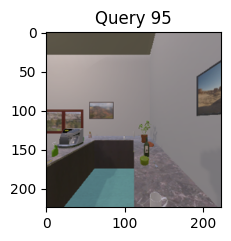

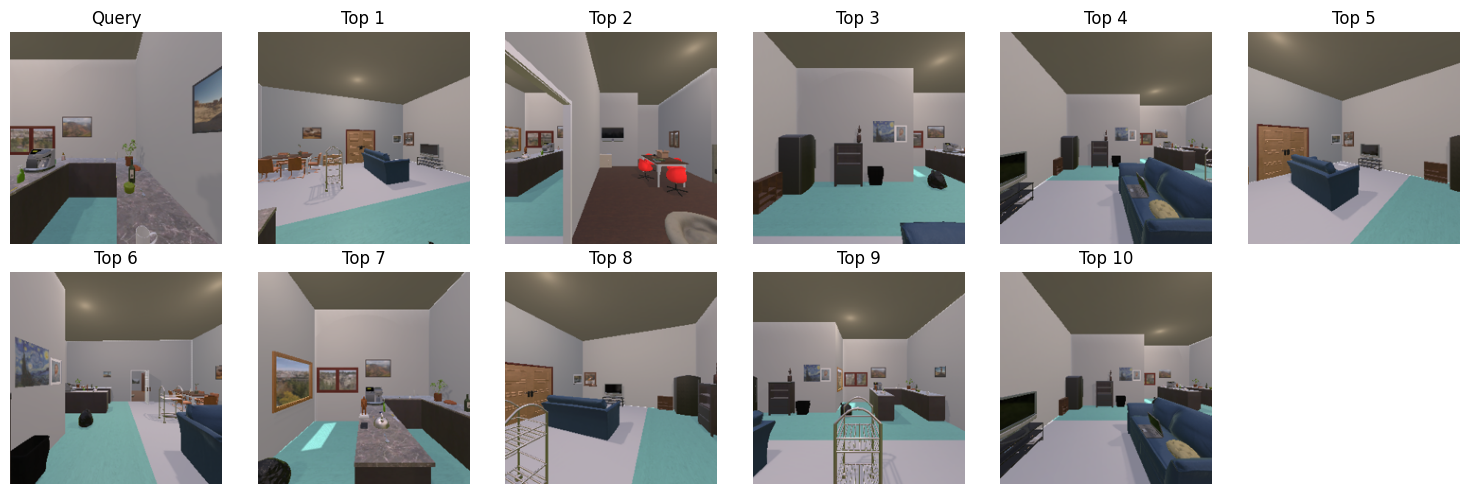

In [103]:
query_id = torch.randint(0, len(dataset), (1,)).item()
query_vector = image_vectors_norm[query_id]

similarities = image_vectors_norm @ query_vector
topk = 10
topk_idx = similarities.argsort(descending=True)[1:topk+1]

print(image_vectors_norm.unique(dim=0).shape)

print(f"Query image index: {query_idx}")
print("Query tags:", dataset_tags[query_idx])
print("\nTop-k most similar frames:")
for rank, idx in enumerate(topk_idx, start=1):
    print(f"{rank:2d}. Image index: {idx.item()}")
    print("   Tags:", dataset_tags[idx.item()])

plt.figure(figsize=(15,5))
plt.subplot(2, (topk+1)//2, 1)
image, _ = dataset[query_idx]
plt.imshow(denormalize(image))
plt.title(f"Query {query_idx}")



plt.figure(figsize=(15,5))
for i, idx in enumerate([query_idx] + topk_idx.tolist()):
    plt.subplot(2, (topk + 1 + 1) // 2 , i + 1)
    image, _ = dataset[idx]
    plt.imshow(denormalize(image))
    title = "Query" if i == 0 else f"Top {i}"
    plt.title(title)
    plt.axis("off")

plt.tight_layout()
plt.show()